# Ising Model
Ising model is one of the more famous models in statistical physics. The system studied in the model has 'spins' located at vertices of a (possibly infinite) lattice, and spins interact with their neighbours using a specific rule (like spins stabilize the energy and unlike spins destabilize the energy) and iteract with external field B; thus  the energy of the system is given as: 
$$ U = - \sum_i B\sigma_i - \frac{1}{2} \sum_{\langle i,j \rangle} J \sigma_i \sigma_j
$$
In the simple version of the model, $\sigma_i = \pm 1$, and system is maintained at temperature $T$; the probability of a particular configuration is given by the Boltzmann Probability Law:
    $ P(\{\sigma_i\}_{i=1}^N) \propto \exp\left[-\beta U(\{\sigma_i\})\right] $
$$

Clearly the probability is then given by 
$$ P(\{ \sigma_i\}_{i=1}^N) \propto \exp\left[ \frac{B}{kT} \sum_i \sigma_i + \frac{J}{2kT}\sum_{\langle i,j\rangle} \sigma_i \sigma_j    \right]
$$
and hence depends on numerical values of  $\frac{B}{kT}$ and $\frac{J}{2kT}$. 

## Periodic Boundary Conditions
To simulate a infinite system, it is common to use Periodic Boundary Conditions (PBC). As illustraition consider 1-dimensional (1D) lattice, which is nothing but a straight line, with $N$ spins placed with equal spacing between two contigious spins. This chain of spins has left-end and right-end making this a finite system; however if we place this chain of spins on a circle such that in addition to requiring that distance between contigious spins is 1 unit, we require the distance betwen left-end and right-end of chain is 1 unit. We now see that the chain becomes *infinite*.

You can imagine similar trick in 2 dimensions, by requiing PBC in x-direction and y-directions. And, in 3-dimensions, requiring PBC in x-direction, y-direction and z-directions. 

### A specific trick applicable only for Ising Model for periodic boundary conditions
Add one extra row and one extra column to the configuration; the additional column/row is the copy of first column/row. 

## For Ising model, write following functions. Assume 2-dimensional model.
Set $J=1$ without loss of generality. See http://web.mit.edu/krish_s/www/files/ising_Model.pdf  page-27 has $m\, vs\, T$ plot

1. Write function to compute energy (using periodic boundary conditions): `Ising2D_Energy`
3. Write a function for magnetisation `Ising_Magnetisation` for $m(T,B)$
4. Write a function for computing heat capacity `Ising_HeatCapacity` for $C_V(T,B)$: $$C_V = \frac{1}{k_B T^2}\langle (E-\bar{E})^2\rangle = \frac{1}{k_B T^2} \left( \langle E^2 \rangle - \langle E \rangle^2 \right)$$
5. Write a function `Ising_SingleFlip_Metropolis` to perform one step of Metroplis Monte Carlo simulation
6. Write a function  `Ising_StoreConfig` to store configuration
7. Perform Monte Carlo Simulation of Ising Model
8. Plot $m(T,B=0)$ vs. $kT/J$. Hint: $kT/J \approx 2.5$ for critical temperature of Ising model. 

## Initialisations

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy

N = 25
J = 1
K = 1

lattice = numpy.ones((N, N), numpy.int8)
for i in range(N):
    for j in range(N):
        lattice[i][j] = random.choices([1, -1], weights=[0.9, 0.1])[0]


Here lattice is in a random state initially, but a larger fraction are aligned with spin
1 as opposed to spin -1 (weight for +1 is more than weight for -1)

### Function to compute energy (Task 1)

In [2]:
def Ising2D_Energy(matrix, b):
    s1 = s2 = 0
    for i in range(N):
        for j in range(N):
            s1 += matrix[i][j]
            s2 += matrix[i][j] * (matrix[(i + 1) % N][j] + matrix[i][(j + 1) % N])

    return -b * s1 - J * s2

print("Test run: Energy of current lattice (at b = 0) is", Ising2D_Energy(lattice, 0))


Test run: Energy of current lattice (at b = 0) is -846


### Function to compute magnetisation (Task 2)

In [3]:
def Ising_Magnetisation(matrix):
    return numpy.sum(matrix)

print("Test run: Magnetization of current lattice is", Ising_Magnetisation(lattice))


Test run: Magnetization of current lattice is 513


### Helper function to set (i, j)th state in the lattice (Task 5)

In [4]:
# handles a "flip" at given x, y. Takes in old matrix, energy and magnetization and 
# returns new values for it
def Ising_StoreConfig(matrix, cur_energy, cur_magnetization, x, y, b):
    ret = matrix.copy()
    old_val = ret[x][y]
    ret[x][y] *= -1
    del_val = ret[x][y] - old_val
    new_magnetization = cur_magnetization + del_val
    new_energy = (
        cur_energy
        - b * del_val
        - J
        * del_val
        * (
            ret[(x - 1) % N][y]
            + ret[(x + 1) % N][y]
            + ret[x][(y - 1) % N]
            + ret[x][(y + 1) % N]
        )
    )
    return ret, new_energy, new_magnetization


### Function to generate the next step in the metropolis monte carlo sampling (Task 4)

In [5]:
def p_acc(e1, e2, t):
    fac = (e1 - e2) / (K * t)
    if fac >= 0:
        return 1

    return math.exp(fac)


# returns a new matrix obtained after doing a flip, and its energy and magnetization
# (for increasing efficiency)
def Ising_SingleFlip_Metropolis(matrix, cur_energy, cur_magnetization, t, b):
    x, y = random.randrange(N), random.randrange(N)
    ret, new_energy, new_magnetization = Ising_StoreConfig(
        matrix, cur_energy, cur_magnetization, x, y, b,
    )

    if random.random() >= p_acc(cur_energy, new_energy, t):
        return matrix, cur_energy, cur_magnetization
    else:
        return ret, new_energy, new_magnetization


### Monte carlo simulation of Ising model (Task 6)

In [6]:
def monte_carlo(initial_lattice, t, b, num_samples=200):
    lattices = [
        (
            initial_lattice,
            Ising2D_Energy(initial_lattice, b),
            Ising_Magnetisation(initial_lattice),
        )
    ]
    for _ in range(num_samples):
        lattices.append(Ising_SingleFlip_Metropolis(*lattices[-1], t, b))

    return lattices


#### Plot of energy with t using the above function

Text(0, 0.5, 'Energy (T = 1, B = 0)')

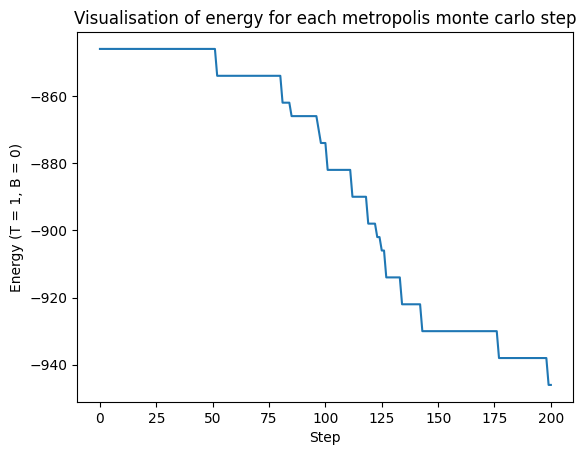

In [7]:
plt.plot([i[1] for i in monte_carlo(lattice, 1, 0)])
plt.title("Visualisation of energy for each metropolis monte carlo step")
plt.xlabel("Step")
plt.ylabel("Energy (T = 1, B = 0)")


### Function for computing heat capacity (Task 3)

In [8]:
def Ising_HeatCapacity(matrix, t, b):
    energies = numpy.array([l[1] for l in monte_carlo(matrix, t, b)])
    fac = 1 / (K * math.pow(t, 2))
    return fac * (numpy.mean(energies**2) - math.pow(numpy.mean(energies), 2))

print("Heat capacity (at T = 10, B = 0) is:", Ising_HeatCapacity(lattice, 10, 0))

Heat capacity (at T = 10, B = 0) is: 131.8360634637758


### Plot of $m(T,B=0)$ vs. $kT/J$ (Task 7) 

(takes about ~5 seconds to run)

Text(0.5, 1.0, 'Plot of m(T, B=0) vs kT/J')

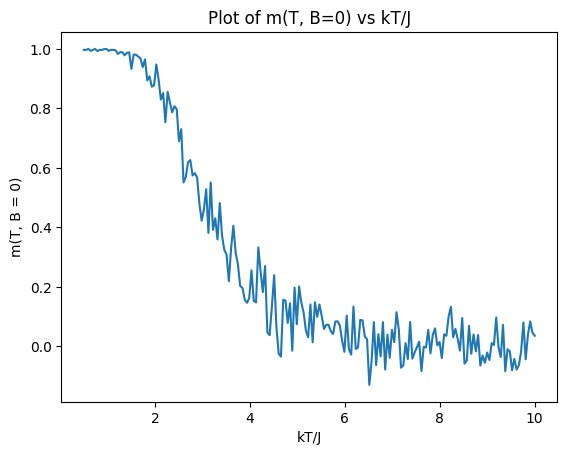

In [9]:
B = 0

x_vals = []
y_vals = []
for t in numpy.linspace(0.5, 10, 200):
    equilibriated_state = monte_carlo(lattice, t, B, 3000)[-1][0]
    x_vals.append(K * t / J)
    y_vals.append(
        sum(l[2] for l in monte_carlo(equilibriated_state, t, B)) / (201 * N * N)
    )

plt.plot(x_vals, y_vals)
plt.xlabel("kT/J")
plt.ylabel(f"m(T, {B = })")
plt.title("Plot of m(T, B=0) vs kT/J")


As expected, there is a sharp dip somewhere $kT/J \in [2, 3] $ region in the graph. This indicates the critical temperature of the ising model (which is calculated to be around 2.3-2.5). Before this critical temperature, m is very close to 1. After the sharp fall it approaches 0 and stays in that region. This explains why magnets loose their magnetic properties when higher temperatures (above this critical temperature) are applied.